Мультивариативный ряд: история цен и объём торгов курса эфириума к доллару США.<br>
Данные охватывают период за c января 2020 года по март 2021 года.<br>
Решаем задачу регресии.

1. Мультивариативный ряд
2. Задача классификации или задача регрессии
3. Блок предобрабоки временного ряда
4. Не менее 3х способов выделения свойств из временного ряда
5. Не менее 2 классических  и 3 нейронок для прогнозирования (или классификации) временного ряда
6. Не менее 5 метрик по каждой модели
7. Выводы по каждой модели, и по результатам в целом.


In [506]:
# 2020-01-01 00:00:00

import pandas as pd
import matplotlib.pyplot as plt

file_path = 'data/gemini_ETHUSD_2020_1min.csv'
data = pd.read_csv(file_path, index_col=False)
del data['Symbol']
del data['Unix Timestamp']
data.reset_index(drop=True, inplace=True)

data['Date'] = pd.to_datetime(data['Date'])
min_time = data['Date'].min()
data['Time'] = ((data['Date'] - min_time).dt.total_seconds() / 60).astype(int)
del data['Date']

data = data.iloc[::-1].reset_index(drop=True)

In [507]:
data

,Open,High,Low,Close,Volume,Time
0,128.84,128.84,128.74,128.74,0.010000,0
1,128.74,128.74,128.74,128.74,0.000000,1
2,128.74,128.74,128.74,128.74,0.000000,2
3,128.74,128.74,128.74,128.74,0.000000,3
4,128.74,128.74,128.49,128.50,4.039458,4
...,...,...,...,...,...,...
658054,2166.54,2166.54,2162.36,2162.69,23.615627,683999
658055,2162.69,2176.00,2162.69,2172.16,33.165910,684000
658056,2172.16,2177.59,2168.63,2168.63,15.458851,684001
658057,2168.63,2168.63,2155.88,2155.88,30.750737,684002


Разделение на обучающую и валидационную выборки<br>

Данные были обрезаны до 10000 в силу экономии времени. Как бы не хотелось, но огромное количество данных сильно влияет на скорость обучения моделей (даже тест Дики-Фуллера выполнялся 10 минут)

In [508]:
data = data[:10000]

## Блок предобработки временного ряда
### Свойства временных рядов

Просмотр основной информации о мультивариационном ряде

In [509]:
data

,Open,High,Low,Close,Volume,Time
0,128.84,128.84,128.74,128.74,0.010000,0
1,128.74,128.74,128.74,128.74,0.000000,1
2,128.74,128.74,128.74,128.74,0.000000,2
3,128.74,128.74,128.74,128.74,0.000000,3
4,128.74,128.74,128.49,128.50,4.039458,4
...,...,...,...,...,...,...
9995,141.67,141.80,141.67,141.70,1.722348,9995
9996,141.70,141.93,141.70,141.83,0.042320,9996
9997,141.83,142.01,141.83,141.93,1.490466,9997
9998,141.93,142.01,141.93,141.93,0.042284,9998


In [510]:
data.describe()

,Open,High,Low,Close,Volume,Time
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,134.600512,134.628508,134.575524,134.601820,10.586502,4999.50000
std,5.106359,5.114572,5.101580,5.106559,68.862374,2886.89568
min,125.600000,125.600000,125.600000,125.600000,0.000000,0.00000
25%,130.070000,130.070000,130.060000,130.070000,0.000000,2499.75000
50%,133.610000,133.640000,133.590000,133.610000,0.000000,4999.50000
75%,138.950000,138.970000,138.930000,138.952500,0.250000,7499.25000
max,145.280000,148.970000,145.210000,145.280000,4213.207374,9999.00000


Зависимость рядов от времени

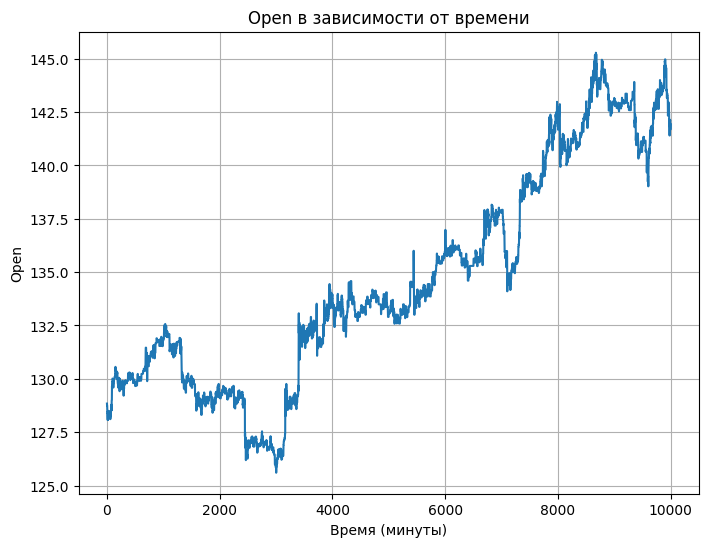

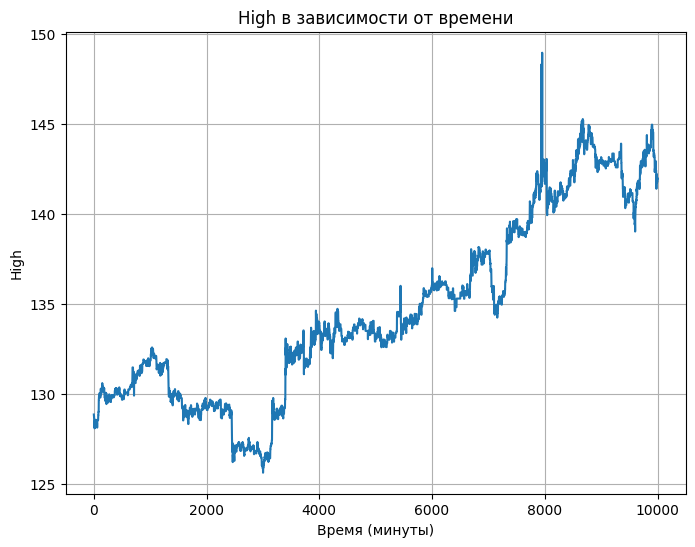

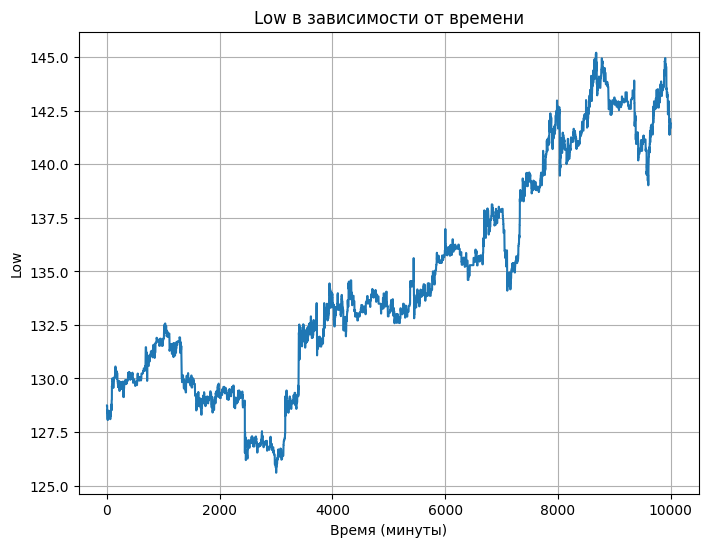

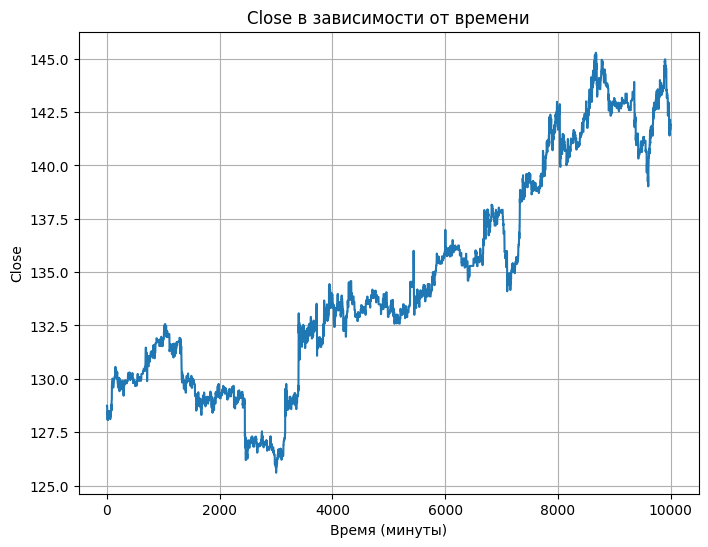

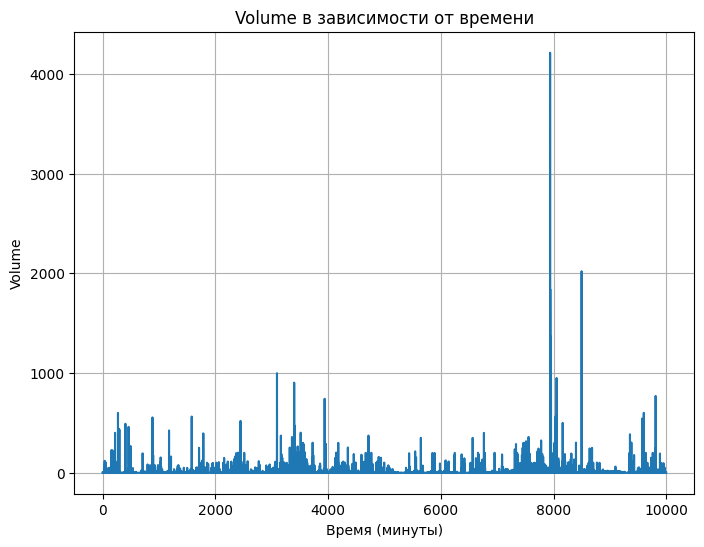

In [511]:
columns_to_plot = ['Open', 'High', 'Low', 'Close', 'Volume']

for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    plt.plot(data['Time'], data[column])
    plt.title(f'{column} в зависимости от времени')
    plt.xlabel('Время (минуты)')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

In [512]:
data

,Open,High,Low,Close,Volume,Time
0,128.84,128.84,128.74,128.74,0.010000,0
1,128.74,128.74,128.74,128.74,0.000000,1
2,128.74,128.74,128.74,128.74,0.000000,2
3,128.74,128.74,128.74,128.74,0.000000,3
4,128.74,128.74,128.49,128.50,4.039458,4
...,...,...,...,...,...,...
9995,141.67,141.80,141.67,141.70,1.722348,9995
9996,141.70,141.93,141.70,141.83,0.042320,9996
9997,141.83,142.01,141.83,141.93,1.490466,9997
9998,141.93,142.01,141.93,141.93,0.042284,9998


Просмотр пропущенных значений во временном ряде

In [514]:
missing_values = data.isnull().sum()
missing_values

Open      0
High      0
Low       0
Close     0
Volume    0
Time      0
dtype: int64

Проверка на то, что все данные передаются через равный промежуток времени.<br>

In [515]:
time_diff = data['Time'].diff()

result = (time_diff == pd.Timedelta(minutes=1)).all()
result

False

Посмотрим на составляющие временного ряда для объёма.

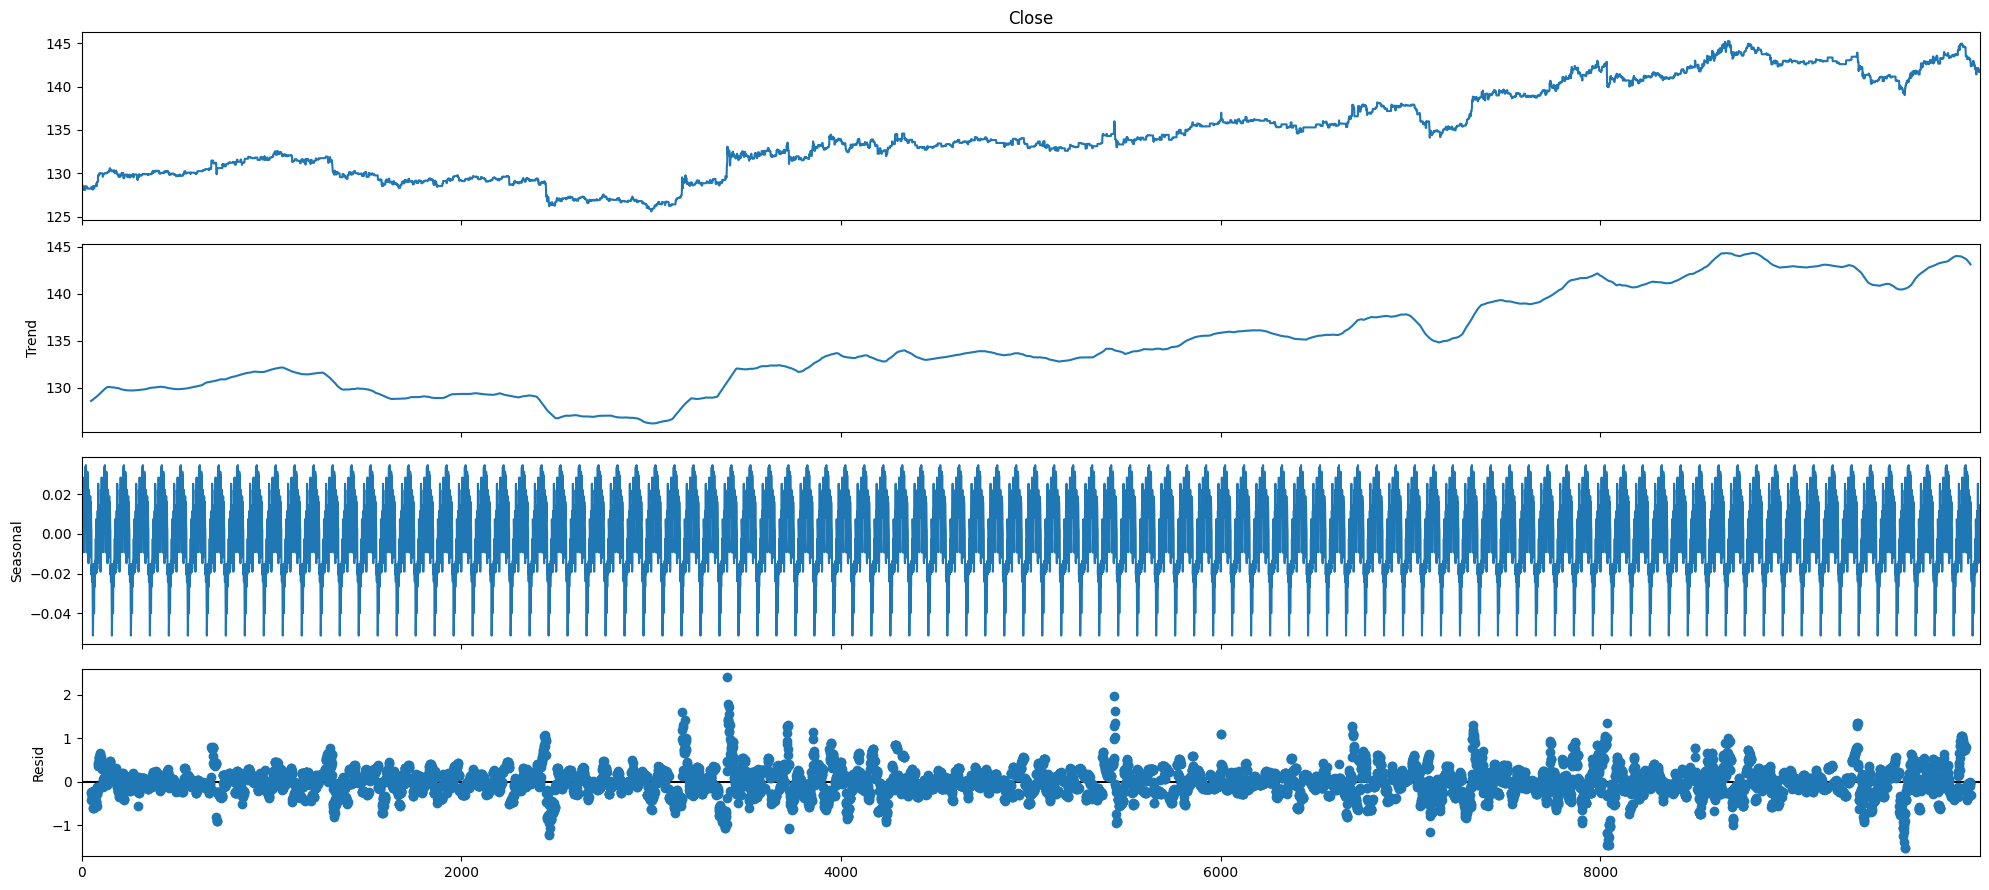

In [516]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 20, 9

decompose = seasonal_decompose(data['Close'], period=100)
decompose.plot()
plt.show()

Из графиков видно, что тренд отсутствуют, сезонность под вопросом.<br>
Есть предположение, что ряд - стационарный.

Проверка ряда на стационарность

In [517]:
from statsmodels.tsa.stattools import adfuller

def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [518]:
df_test("Volume", data["Volume"])

Тест Дики-Фуллера ряда Volume:
Test Statistic                -1.668138e+01
p-value                        1.515358e-29
#Lags Users                    2.000000e+01
Number of Observations Used    9.979000e+03
Critical Value (1%)           -3.431005e+00
Critical Value (5%)           -2.861830e+00
Critical Value (10%)          -2.566924e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Ряд стационарный, значит что все остатки случайны, статистические величины - постоянны.

Посмотрим также на другие ряды.

In [519]:
df_test("Open", data["Open"])

Тест Дики-Фуллера ряда Open:
Test Statistic                   -0.838876
p-value                           0.807435
#Lags Users                      12.000000
Number of Observations Used    9987.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [520]:
df_test("High", data["High"])

Тест Дики-Фуллера ряда High:
Test Statistic                   -0.842212
p-value                           0.806407
#Lags Users                      32.000000
Number of Observations Used    9967.000000
Critical Value (1%)              -3.431006
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [521]:
df_test("Low", data["Low"])

Тест Дики-Фуллера ряда Low:
Test Statistic                   -0.814705
p-value                           0.814764
#Lags Users                      13.000000
Number of Observations Used    9986.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [522]:
df_test("Close", data["Close"])

Тест Дики-Фуллера ряда Close:
Test Statistic                   -0.842488
p-value                           0.806322
#Lags Users                      12.000000
Number of Observations Used    9987.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


Для прогнозирования в моделях VAR, VARMA, VARMA важна стационарность.<br>
Для нейронок это уже необязательно.

Попробуем дифференцирование, чтобы сделать ряды стационарными.<br>
P.S. Пробовал преобразование Бокса-Кокса - оно не помогает делать ряды стационарными.

In [529]:
differenced_series = data.diff().dropna()

,Open,High,Low,Close,Volume,Time
0,128.84,128.84,128.74,128.74,0.010000,0
1,128.74,128.74,128.74,128.74,0.000000,1
2,128.74,128.74,128.74,128.74,0.000000,2
3,128.74,128.74,128.74,128.74,0.000000,3
4,128.74,128.74,128.49,128.50,4.039458,4
...,...,...,...,...,...,...
9995,141.67,141.80,141.67,141.70,1.722348,9995
9996,141.70,141.93,141.70,141.83,0.042320,9996
9997,141.83,142.01,141.83,141.93,1.490466,9997
9998,141.93,142.01,141.93,141.93,0.042284,9998


In [504]:
df_test("Volume", differenced_series["Volume"])

Тест Дики-Фуллера ряда Volume:
Test Statistic                  -25.803724
p-value                           0.000000
#Lags Users                      38.000000
Number of Observations Used    9960.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [505]:
df_test("Open", differenced_series["Open"])

Тест Дики-Фуллера ряда Open:
Test Statistic                   -0.838876
p-value                           0.807435
#Lags Users                      12.000000
Number of Observations Used    9987.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [470]:
df_test("High", differenced_series["High"])

Тест Дики-Фуллера ряда High:
Test Statistic                  -43.297613
p-value                           0.000000
#Lags Users                      38.000000
Number of Observations Used    9957.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566925
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [471]:
df_test("Low", differenced_series["Low"])

Тест Дики-Фуллера ряда Low:
Test Statistic                  -43.790836
p-value                           0.000000
#Lags Users                      38.000000
Number of Observations Used    9957.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566925
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [472]:
df_test("Close", differenced_series["Close"])

Тест Дики-Фуллера ряда Close:
Test Statistic                  -43.919627
p-value                           0.000000
#Lags Users                      38.000000
Number of Observations Used    9957.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566925
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Посмотрим на автокорреляцию.

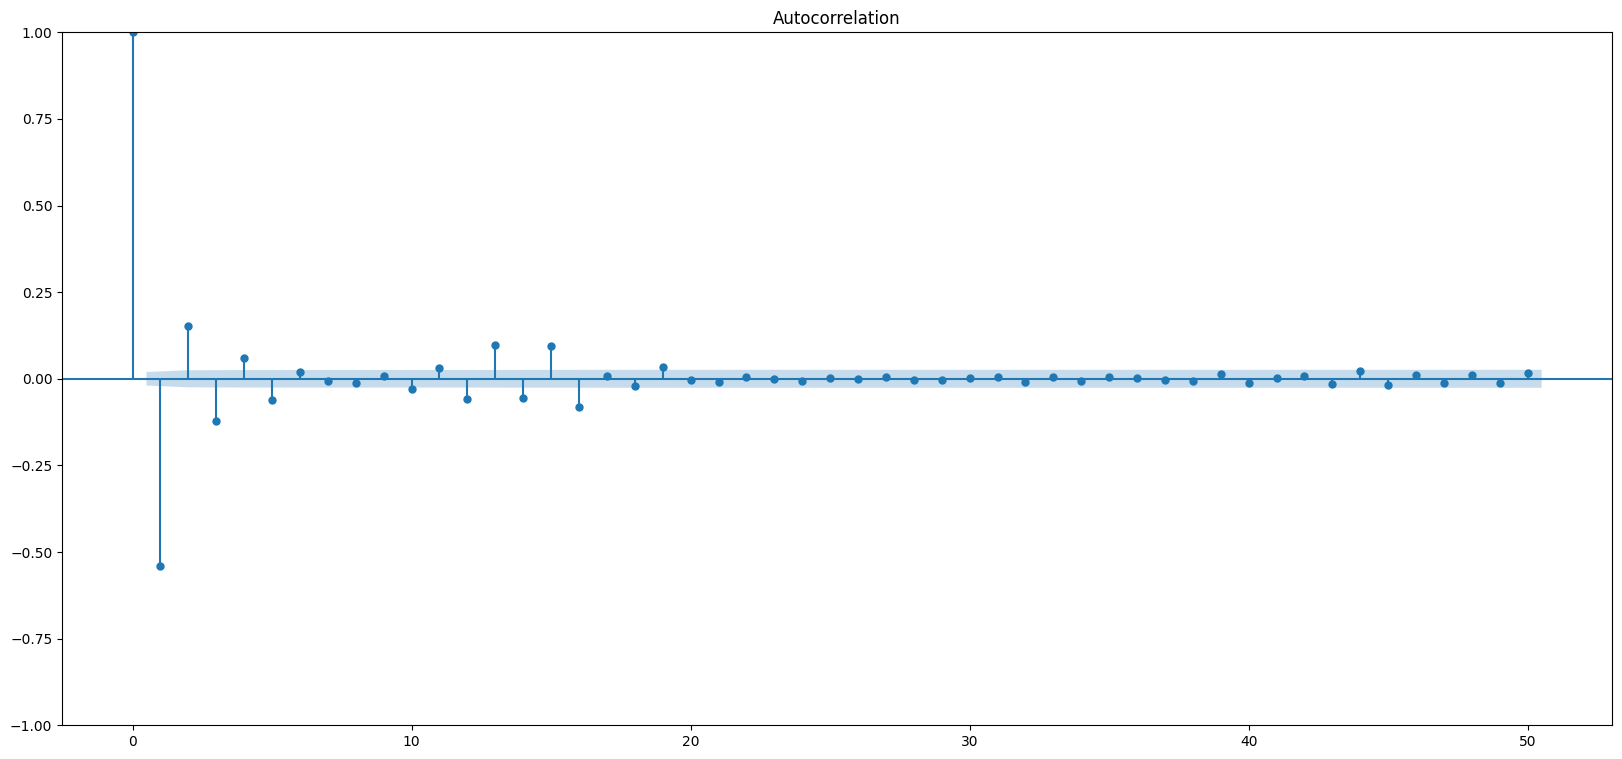

In [474]:
import statsmodels.tsa.api as smt

acf_plot = smt.graphics.plot_acf(differenced_series['Volume'], lags=50)
plt.show()

К/ф корреляции не меняют знак, к тому же он плюс минус, начиная с 20 лага - одинаковый.<br>
Это подтверждает тест Дики-Фуллера, что ряд - стационарный, значит шумы в ряде - случайны.<br>
Прогнозировать будет легче.

#### Прогнозирование временного ряда

Первая модель - VARMA. Для начала - подберем оптимальные параметры.

In [ ]:
from itertools import product
import warnings
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm

columns = ['Open', 'High', 'Low', 'Close', 'Volume']

train, test = differenced_series[columns].values, validation[columns].values
size = len(train)

p = range(0, 20)
q = range(0, 20) 
pq = list(product(p, q))

best_aic = float("inf")
best_params = None

for param in pq:
    try:
        model = VARMAX(train, order=param)
        results = model.fit(maxiter=1000, disp=False)
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            
    except Exception as e:
        print(f"Error for model with parameters {param}: {e}")

print(f"Best AIC: {best_aic}")
print(f"Best Parameters: {best_params}")

In [476]:
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
train, test = differenced_series[:7000][columns], differenced_series[7000:][columns].values
size = len(train)

model = VARMAX(train, order=(1, 1))
model_fit = model.fit(disp=False)

predictions = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))

for i, col in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    plt.plot(test[:, i], label='True')
    plt.plot(predictions[:, i], label='Predicted')
    plt.title(f'VarMAX Prediction for {col}')
    plt.legend()

plt.tight_layout()
plt.show()

c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Иван\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'


KeyboardInterrupt: 

Метрики!!!!

In [404]:
import numpy as np

def smape_score(actual, predicted) -> float: 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual)) / 2) 
        ), 3
    ) 

In [405]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
smape = smape_score(test, predictions)
r2 = r2_score(test, predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("SMAPE:", smape)
print("R^2:", r2)

ValueError: Found input variables with inconsistent numbers of samples: [3000, 300]